# Machine failure prediction

## Introduction

In the field of industrial maintenance and operations, the timely detection of machine failures is crucial to prevent unexpected downtime, minimize production losses, and optimize maintenance strategies. Machine learning techniques have emerged as valuable tools for predicting and classifying data. However, the effectiveness of such models heavily relies on the quality and balance of the dataset used for training.

Throughout this project, I will explore different techniques for addressing class imbalance, including oversampling and undersampling methods. Additionally, I will investigate the impact of various feature engineering strategies, such as dimensionality reduction and feature selection, to improve the model's ability to discriminate between healthy and failing machines.

The performance of the developed binary classification models will be evaluated using accuracy, consufion matrix and area under the receiver operating characteristic curve (AUC-ROC). The results will be compared with a baseline model trained on the original unbalanced dataset, highlighting the effectiveness of the proposed techniques in improving the model's performance on the minority class (failure machines).

In [0]:
!pip install yellowbrick

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


## Loading the train data uploaded to Databricks previously

In [0]:
def load_datasets(files_location, file_type):
    for file_location in files_location:
        # CSV options
        infer_schema = "false"
        first_row_is_header = "true"
        delimiter = ","

        # The applied options are for CSV files. For other file types, these will be ignored.
        df = spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .load(file_location)
        yield df

In [0]:
# File location and type
files_location = ["/FileStore/tables/train.csv", "/FileStore/tables/test.csv"]
file_type = "csv"

train, test = load_datasets(files_location, file_type)

In [0]:
train.limit(5).toPandas()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [0]:
test.limit(5).toPandas()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


### Feature Engineer

In [0]:
from pyspark.sql.functions import regexp_replace, col

def rename_lower_columns(dfs):
    for df in dfs:
        # Replace columns spaces to underscores
        df = df.withColumnRenamed("Product Id", "product_id")\
                .withColumnRenamed("Air temperature [K]", "air_temperature")\
                .withColumnRenamed("Process temperature [K]", "process_temperature")\
                .withColumnRenamed("Rotational speed [rpm]", "rotational_speed")\
                .withColumnRenamed("Torque [Nm]", "torque")\
                .withColumnRenamed("Tool wear [min]", "tool_wear")\
                .withColumnRenamed("machine failure", "machine_failure")

        # Lower all columns name
        df = df.select([c.lower() for c in df.columns])

        # Remove unwanted characters from columns name
        df = df.select([regexp_replace(col(c), "[ ,;{}()\n\t=]", "").alias(c) for c in df.columns])

        # Drop missing values
        df.dropna()
        yield df

In [0]:
train, test = rename_lower_columns([train, test])

In [0]:
train.limit(5).toPandas()

,id,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


### Saving data

In [0]:
# Save table

spark.sql("DROP TABLE IF EXISTS train_csv")
spark.sql("DROP TABLE IF EXISTS test_csv")

train.write.mode("overwrite").option("header", "true").option("overwriteSchema", "True").format("csv")\
    .option("path", "/tables/train")\
    .saveAsTable("train")

test.write.mode("overwrite").option("header", "true").option("overwriteSchema", "True").format("csv")\
    .option("path", "/tables/test")\
    .saveAsTable("test")

## Exploratory Data Analysis

#### Loading the table using Apache Spark SQL

First, we need to aggregate our data to make it useful for analysis. The aggregation or summarization is a process that 

In [0]:
%sql

-- Aggregate features for analysis
CREATE OR REPLACE TABLE train_table
USING DELTA LOCATION "/tables/train_data"
AS (
  SELECT
    first(type) AS type,
    first(machine_failure) AS machine_failure,
    MAX(CAST(air_temperature AS INT)) AS max_air_temperature,
    MIN(CAST(air_temperature AS INT)) AS min_air_temperature,
    AVG(CAST(air_temperature AS INT)) AS avg_air_temperature,
    MAX(CAST(process_temperature AS INT)) AS max_process_temperature,
    MIN(CAST(process_temperature AS INT)) AS min_process_temperature,
    AVG(CAST(process_temperature AS INT)) AS avg_process_temperature,
    MAX(CAST(rotational_speed AS INT)) AS max_rotational_speed,
    MIN(CAST(rotational_speed AS INT)) AS min_rotational_speed,
    AVG(CAST(rotational_speed AS INT)) AS avg_rotational_speed,
    MAX(CAST(torque AS INT)) AS max_torque,
    MIN(CAST(torque AS INT)) AS min_torque,
    AVG(CAST(torque AS INT)) AS avg_torque,
    MAX(CAST(tool_wear AS INT)) AS max_tool_wear,
    MIN(CAST(tool_wear AS INT)) AS min_tool_wear,
    AVG(CAST(tool_wear AS INT)) AS avg_tool_wear
  FROM train
  GROUP BY product_id
)


num_affected_rows,num_inserted_rows


**Using the DESCRIBE function to output table details such as data type**

In [0]:
%sql
-- Print table details 
DESCRIBE EXTENDED train_table

col_name,data_type,comment
type,string,null
machine_failure,string,null
max_air_temperature,int,null
min_air_temperature,int,null
avg_air_temperature,double,null
max_process_temperature,int,null
min_process_temperature,int,null
avg_process_temperature,double,null
max_rotational_speed,int,null
min_rotational_speed,int,null


In [0]:
%sql

-- Select the first 10 rows
SELECT * 
FROM train_table
LIMIT 10

type,machine_failure,max_air_temperature,min_air_temperature,avg_air_temperature,max_process_temperature,min_process_temperature,avg_process_temperature,max_rotational_speed,min_rotational_speed,avg_rotational_speed,max_torque,min_torque,avg_torque,max_tool_wear,min_tool_wear,avg_tool_wear
H,0,298,298,298.0,309,309,309.0,1487,1487,1487.0,36,36,36.0,35,35,35.0
H,0,298,298,298.0,309,308,308.75,1522,1412,1445.0,60,34,44.5,33,16,26.75
H,0,298,298,298.0,309,309,309.0,1436,1306,1349.3333333333333,54,54,54.0,203,21,91.33333333333333
H,0,298,298,298.0,309,309,309.0,1393,1393,1393.0,52,52,52.0,167,167,167.0
H,0,299,298,298.6,309,308,308.6,1678,1379,1514.8,49,24,33.0,208,0,116.8
H,0,299,297,298.125,309,308,308.75,1834,1339,1533.375,51,23,39.5,134,0,82.125
H,0,298,298,298.0,309,309,309.0,1466,1397,1431.5,44,44,44.0,179,120,149.5
H,0,298,298,298.0,309,308,308.8888888888889,2449,1369,1606.6666666666667,53,13,38.888888888888886,200,0,116.66666666666667
H,0,298,298,298.0,309,308,308.3333333333333,1457,1436,1446.3333333333333,44,43,43.333333333333336,147,2,68.33333333333333
H,0,298,298,298.0,308,308,308.0,1611,1368,1460.3333333333333,47,33,42.333333333333336,127,14,78.83333333333333


In [0]:
%sql

-- Plot total observations by machine type
SELECT type, count(*) AS total
FROM train_table
GROUP BY type

type,total
L,5995
M,2985
H,996


Databricks visualization. Run in Databricks to view.

This plot displays the distribution of machine types based on the total number of machines. Ideally, we aim for a relatively balanced distribution across all machine types. Having a similar number of machines for each type ensures that our model is not biased or overly influenced by the machine type feature.

In [0]:
%sql 

-- Plot total observations by machine status (failure or not)
SELECT type, machine_failure, COUNT(*) AS total
FROM train_table
GROUP BY type, machine_failure

type,machine_failure,total
M,1,39
L,0,5883
H,0,984
H,1,12
L,1,112
M,0,2946


Databricks visualization. Run in Databricks to view.

This plot reveals an important insight: the failure percentage does not exceed 2% for any machine type. This information indicates that our dataset is unbalanced, as there is a significant difference in the failure occurrences across machine types. From a modeling perspective, it is crucial to address this class imbalance issue to ensure that it does not adversely impact the model's performance.

## Feature Store

Now we can write our features to Databricks Feature Store. The Feature store serves as the consumption layer for ML applications.

* Databricks stores features in a Delta Lake table
* Permits discoverability and reusability of our features
* Enhance traceability and governance in our deployment by providing insights into the dependencies between models and their corresponding sets of features.
* Can serve both real-time and batch-based ML inference 
* Is designed to handle large volumes of data efficiently, making it scalable to meet the needs of data-intensive ML applications

In [0]:
"""from databricks.feature_store import feature_table
from databricks.feature_store import FeatureStoreClient

# Instantiate a new FeatureStoreClient
fs = FeatureStoreClient()

# Define the feature store table name
dbName = "machine_failure_features"
table_name = "f{dbName}.dbmachine_failure_features"

# Drop table if exists
try:
    fs.drop_table(table_name)
except:
    pass

# Create feature store table
machine_feature_table = fs.create_table(name=table_name, 
                                        primary_keys='product_id',
                                        schema=train.schema(),
                                        description="These features are derived from the machine_failure_train table in the lakehouse.  We cleaned up their names. Data aggregation were performed by minimum, maximum, and average.")
# Write table
fs.write_table(df=train, name=table_name, mode="overwrite")"""
                                        

2023/09/16 18:24:55 ERROR databricks.feature_store.utils.rest_utils: API request to https://community.cloud.databricks.com/api/2.0/feature-store/feature-tables/get failed with code 503, retrying up to 2 more times. API response body: {"error_code":"TEMPORARILY_UNAVAILABLE","message":"The service at /api/2.0/feature-store/feature-tables/get is temporarily unavailable. Please try again later."}
2023/09/16 18:24:58 ERROR databricks.feature_store.utils.rest_utils: API request to https://community.cloud.databricks.com/api/2.0/feature-store/feature-tables/get failed with code 503, retrying up to 1 more times. API response body: {"error_code":"TEMPORARILY_UNAVAILABLE","message":"The service at /api/2.0/feature-store/feature-tables/get is temporarily unavailable. Please try again later."}
2023/09/16 18:25:02 ERROR databricks.feature_store.utils.rest_utils: API request to https://community.cloud.databricks.com/api/2.0/feature-store/feature-tables/get failed with code 503, retrying up to 0 more 

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-2134851002186792>, line 20
     15     pass
     17 # Create feature store table
     18 machine_feature_table = fs.create_table(name=table_name, 
     19                                         primary_keys='product_id',
---> 20                                         schema=train.schema(),
     21                                         description="These features are derived from the machine_failure_train table in the lakehouse.  We cleaned up their names. Data aggregation were performed by minimum, maximum, and average.")
     22 # Write table
     23 fs.write_table(df=train, name=table_name, mode="overwrite")

TypeError: 'StructType' object is not callable

## Modeling

**Benchmark Model**

In [0]:
# Read table 
df = spark.table("train_table").toPandas()
df.head(5)

,type,machine_failure,max_air_temperature,min_air_temperature,avg_air_temperature,max_process_temperature,min_process_temperature,avg_process_temperature,max_rotational_speed,min_rotational_speed,avg_rotational_speed,max_torque,min_torque,avg_torque,max_tool_wear,min_tool_wear,avg_tool_wear
0,H,0,298,298,298.0,309,309,309.00,1487,1487,1487.000000,36,36,36.0,35,35,35.000000
1,H,0,298,298,298.0,309,308,308.75,1522,1412,1445.000000,60,34,44.5,33,16,26.750000
2,H,0,298,298,298.0,309,309,309.00,1436,1306,1349.333333,54,54,54.0,203,21,91.333333
3,H,0,298,298,298.0,309,309,309.00,1393,1393,1393.000000,52,52,52.0,167,167,167.000000
4,H,0,299,298,298.6,309,308,308.60,1678,1379,1514.800000,49,24,33.0,208,0,116.800000


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

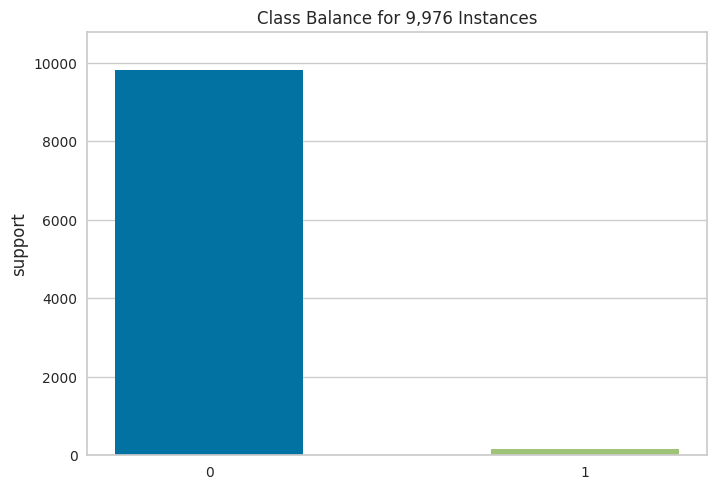

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 9,976 Instances'}, ylabel='support'>)

In [0]:
from yellowbrick.target import class_balance

X = df.drop("machine_failure", axis=1)
y = df["machine_failure"]

class_balance(y)    


In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

y_scores = []

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Preprocess categorical and numerical features separately
categorical_features = ['type']
numerical_features = df.drop(["type", "machine_failure"], axis=1).columns

# Create transformers for each feature type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Create a pipeline
benchmark = make_pipeline(preprocessor, LogisticRegression())

# Fit the pipeline to the train set
benchmark.fit(X_train, y_train)

# Compute probabilities
y_score = benchmark.predict_proba(X_val)
y_scores.append(y_score)

# Compute the accuracy score in the validation set
print(benchmark.score(X, y))


/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9836607858861267


The accuracy value achieved is remarkably high, with nearly 100% correct predictions. However, it is crucial to address a significant issue that has been mentioned previously. The dataset suffers from a severe class imbalance, with 98% of cases representing non-failure instances. Consequently, our model might struggle to identify failure cases effectively, as there is a 98% chance that simply predicting that a machine is not failing would yield correct results by chance. Now let's look to the AUC ROC curve and the confusion matrix as these metrics can shows a more accurate result.

To gain a more comprehensive understanding of our model's performance, it is recommended to use metrics such as the AUC ROC curve and the confusion matrix. These metrics provide a more accurate assessment of the model's predictive ability, particularly in scenarios with imbalanced datasets. By examining these metrics, we can better evaluate how well our model distinguishes between failure and non-failure cases.

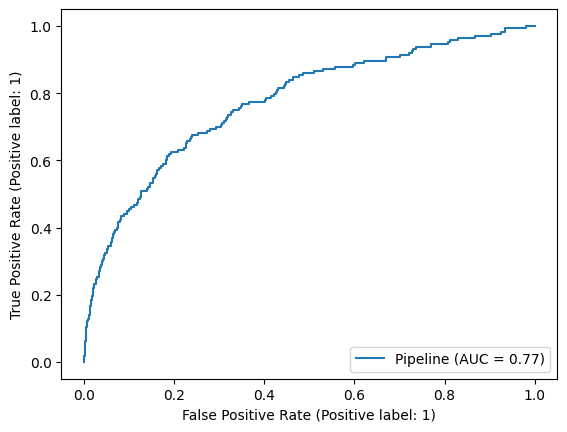

In [0]:
RocCurveDisplay.from_estimator(benchmark, X, y)

Oops! It appears that the AUC ROC curve reveals a different story compared to the initially high accuracy. The plot indicates that our model's performance is not as impressive as the accuracy metric initially suggested. In fact, the AUC ROC curve indicates that our model was able to correctly classify only 77% of the cases. Now let's use the confusion matrix to further investigate what is happening with our model's performance.

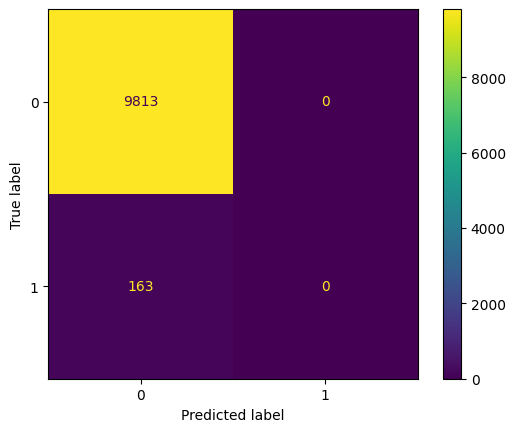

In [0]:
ConfusionMatrixDisplay.from_estimator(benchmark, X, y)

Finally, we have uncovered the truth about our model's performance. Upon closer examination, it becomes evident that our model excelled in classifying non-failure machines. However, when it comes to identifying failure cases, our model fared poorly, failing to correctly classify even a single instance of failure machines.

It is imperative to address the significant imbalance between failure and non-failure cases in our dataset, as any misclassification could have severe consequences. We must now focus on improving our model's ability to accurately identify and classify failure instances, as it is a critical aspect of our application.

## Bootstrap sample the minority class

Randomly duplicate examples in the minority class by sampling with replacement

In [0]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample.fit_resample(X, y)

print(f"Result: {y_over.value_counts()/len(y_over)}")

Result: 0    0.5
1    0.5
Name: machine_failure, dtype: float64


In [0]:
# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_over, y_over, test_size=0.10, random_state=42)

# Preprocess categorical and numerical features separately
categorical_features = ['type']
numerical_features = df.drop(["type", "machine_failure"], axis=1).columns

# Create transformers for each feature type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Create a pipeline
pipeline_over = make_pipeline(preprocessor, LogisticRegression())

# Fit the pipeline to the train set
pipeline_over.fit(X_train, y_train)

# Compute probabilities
y_score = pipeline_over.predict_proba(X_val)
y_scores.append(y_score)

# Compute the accuracy score in the validation set
print(pipeline_over.score(X, y))

0.702485966319166



## Undersample the majority class

Randomly delete examples from the majority class

In [0]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

X_under, y_under = undersample.fit_resample(X, y)

print(f"Result: {y_under.value_counts()/len(y_under)}")

Result: 0    0.5
1    0.5
Name: machine_failure, dtype: float64


In [0]:
# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_under, y_under, test_size=0.10, random_state=42)

# Preprocess categorical and numerical features separately
categorical_features = ['type']
numerical_features = df.drop(["type", "machine_failure"], axis=1).columns

# Create transformers for each feature type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Create a pipeline
pipeline_under = make_pipeline(preprocessor, LogisticRegression())

# Fit the pipeline to the train set
pipeline_under.fit(X_train, y_train)

# Predict the validation set
y_predicted = pipeline_under.predict(X_val)

# Compute probabilities
y_score = pipeline_under.predict_proba(X_val)
y_scores.append(y_score)

# Compute the accuracy score in the validation set
print(pipeline_under.score(X, y))

0.6746190858059342



By using oversampling and undersampling we had a worst accuracy score we before we need to look at others metrics such as confusion matrix and AUC.

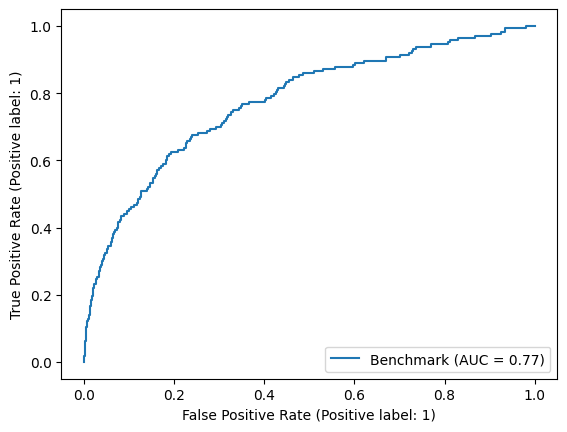

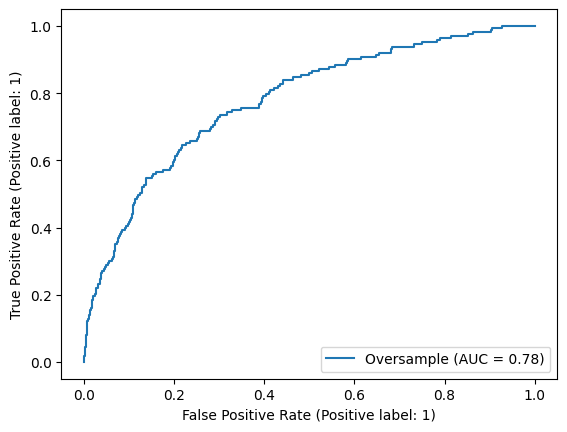

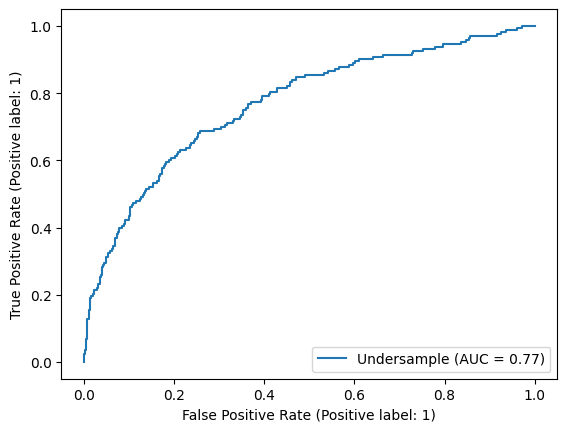

In [0]:

models_name = ["Benchmark", "Oversample", "Undersample"] 
for model, name in zip([benchmark, pipeline_over, pipeline_under], models_name):
    RocCurveDisplay.from_estimator(model, X, y, name=name)

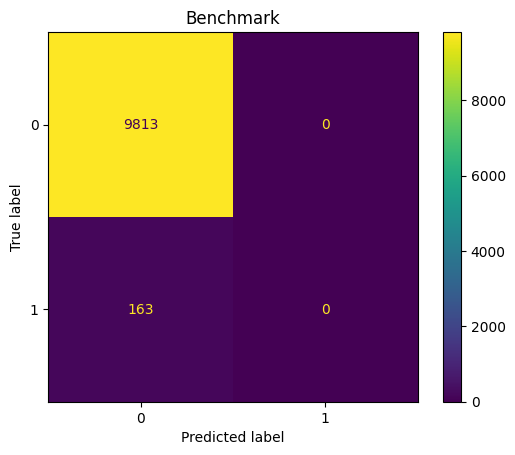

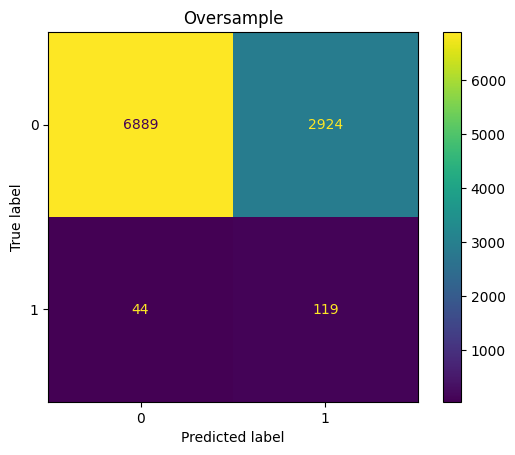

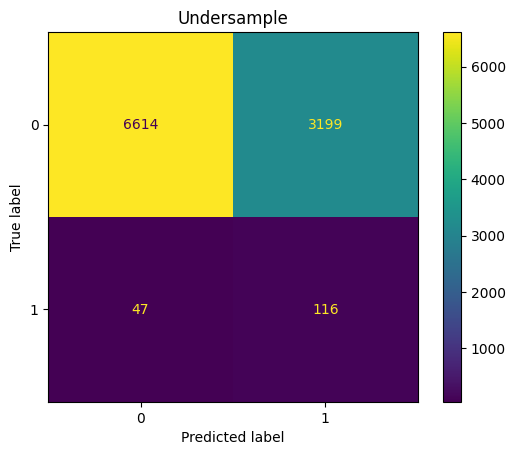

In [0]:
models_name = ["Benchmark", "Oversample", "Undersample"] 
for model, name in zip([benchmark, pipeline_over, pipeline_under], models_name):
    ConfusionMatrixDisplay.from_estimator(model, X, y)
    plt.title(name)
    


## Dimensional reduction using PCA (Principal Component Analysis)


PCA identifies the axes (principal components) along which the data exhibits the most variation, preserving as much of the original data's variance as possible. It is used for data compression, noise reduction, visualization, and feature selection.


/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the follo

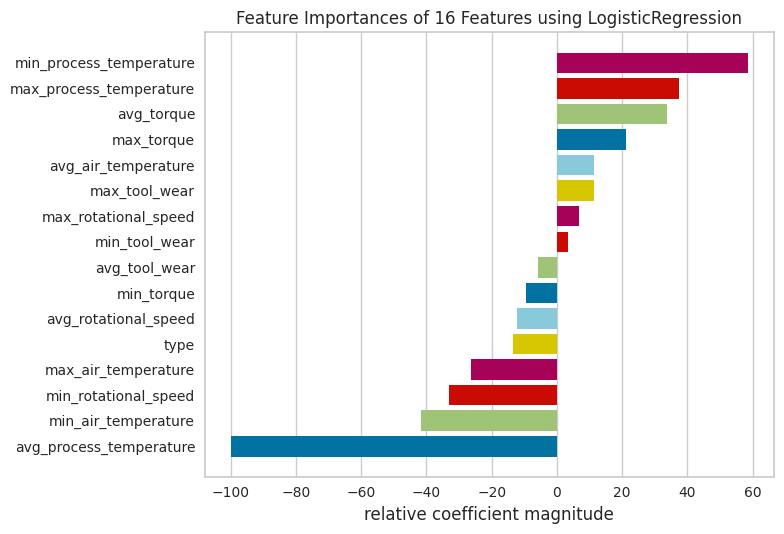

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

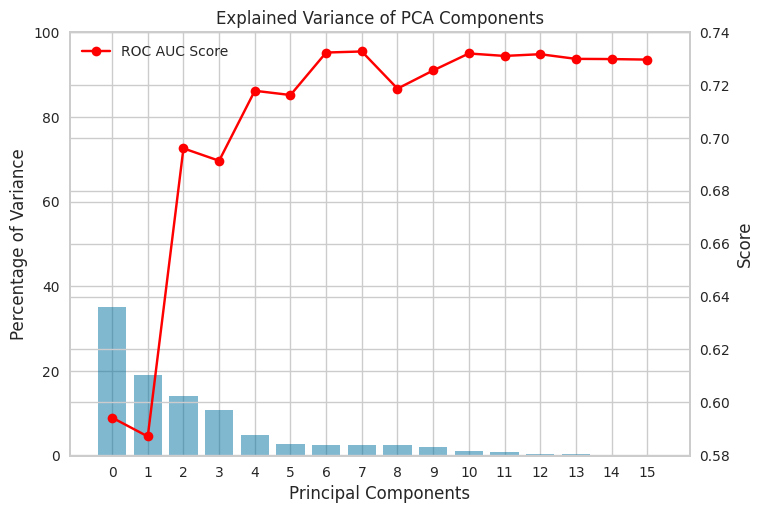

Best n_components: 1


In [0]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from yellowbrick.model_selection import feature_importances
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import class_prediction_error
from yellowbrick.classifier.threshold import discrimination_threshold
from sklearn.metrics import roc_auc_score


best_accuracy = 0
best_n_components = None

n_features = X_train.shape[1]
n_components_range = np.arange(1, n_features + 1)

y_scores = []

X = df.drop("machine_failure", axis=1)
y = df["machine_failure"]

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Preprocess categorical and numerical features separately
categorical_features = ['type']
numerical_features = df.drop(["type", "machine_failure"], axis=1).columns

# Create transformers for each feature type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

accuracy_scores = []
roc_auc_scores = []

for n_components in n_components_range:
    
    # Create a LogisticRegression model
    model = LogisticRegression()
    
    # Create a pipeline
    pipeline = make_pipeline(preprocessor, PCA(n_components=n_components), model)

    # Fit the pipeline to the train set
    pipeline.fit(X_train, y_train)

    # Predict probabilities for the positive class (class 1)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    roc_auc_scores.append(roc_auc)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = n_components
    
    if n_components == len(n_components_range):
        # Plot features importance 
        viz = FeatureImportances(model)
        viz.fit(X, y)
        viz.show()
   
    if n_components == len(n_components_range):
        #  Get the explained variance ratio for each component
        explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_  * 100  

        # Plot the explained variances
        features = range(pipeline.named_steps['pca'].n_components_)

        # Create a bar plot to visualize the explained variance of each component
        plt.bar(features, explained_variance_ratio, alpha=0.5, align='center',
            label='Individual explained variance')
        plt.xlabel('Principal Components')
        plt.ylabel('Percentage of Variance')
        plt.title('Explained Variance of PCA Components')
        plt.ylim(0, 100)
        plt.xticks(features)

        # Create a secondary y-axis for ROC AUC 
        ax2 = plt.twinx()

        # Add a line plot for ROC AUC scores 
        ax2.plot(features, roc_auc_scores, color='red', label='ROC AUC Score', marker='o')
        ax2.set_ylabel('Score')
        plt.legend(loc='upper left')
        plt.show()

print(f"Best n_components: {best_n_components}")